In [1]:
# bibliotecas matetmáticas
import math
import pandas as pd
import numpy as np

# bibliotecas para uso de redes neurais. Neste caso, do tipo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# bibliotecas para o pré-processamento dos dados. Normalização, etc...
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
import datetime
from functools import reduce

# bibliotecas para representação dos dados em gráficos
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# métodos para pré-processamento do DataFrame original
import pre_processing as pp

Leitura do dataset referente ao período de 8:05 até 8:20 da manhã do NGSIM us-101. São lidas as 100 mil primeiras linhas.

In [84]:
%%time
#Leitura dos 100 mil primeiros registros do conjunto de dados

# df1 = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0750am-0805am/trajectories-0750am-0805am.csv', nrows=100000)
# df2 = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0805am-0820am/trajectories-0805am-0820am.csv', nrows=100000)
#df1 = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0750am-0805am/trajectories-0750am-0805am.csv')
df = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0805am-0820am/trajectories-0805am-0820am.csv')
#df = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0820am-0835am/trajectories-0820am-0835am.csv')

# df = pd.concat([df1, df2, df3])
# df = df.reset_index(drop=True)

CPU times: user 1.06 s, sys: 176 ms, total: 1.24 s
Wall time: 1.24 s


In [85]:
df

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00
1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00
2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00
3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00
4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,47.0,8.5,3,19.89,1.07,5,0,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1914,7369,923,1118848578900,6.751,949.584,6451781.160,1872752.182,16.5,6.4,2,14.89,0.31,1,1909,1917,35.13,2.36
1048571,1914,7370,923,1118848579000,6.763,951.072,6451782.284,1872751.189,16.5,6.4,2,14.93,0.64,1,1909,1917,34.97,2.34
1048572,1914,7371,923,1118848579100,6.777,952.570,6451783.407,1872750.195,16.5,6.4,2,14.98,0.34,1,1909,1917,34.82,2.32
1048573,1914,7372,923,1118848579200,6.789,954.072,6451784.531,1872749.202,16.5,6.4,2,15.00,0.00,1,1909,1917,34.66,2.31


Conversão das posições lateral (Local_X) e longitudinal (Local_Y) dos veículos do dataframe de pés para metros e adição dos valores nas colunas Local_X_meters e Local_Y_meters.

In [86]:
df = pp.add_positions_in_meters(df)

In [87]:
df

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy,Local_X_meters,Local_Y_meters
0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00,15.594977,34.405633
1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00,15.591624,35.015240
2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00,15.588576,35.624848
3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,47.0,8.5,3,19.89,0.00,5,0,0,0.00,0.00,15.619361,36.215252
4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,47.0,8.5,3,19.89,1.07,5,0,0,0.00,0.00,15.616313,36.824555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1914,7369,923,1118848578900,6.751,949.584,6451781.160,1872752.182,16.5,6.4,2,14.89,0.31,1,1909,1917,35.13,2.36,2.057730,289.436723
1048571,1914,7370,923,1118848579000,6.763,951.072,6451782.284,1872751.189,16.5,6.4,2,14.93,0.64,1,1909,1917,34.97,2.34,2.061387,289.890271
1048572,1914,7371,923,1118848579100,6.777,952.570,6451783.407,1872750.195,16.5,6.4,2,14.98,0.34,1,1909,1917,34.82,2.32,2.065655,290.346867
1048573,1914,7372,923,1118848579200,6.789,954.072,6451784.531,1872749.202,16.5,6.4,2,15.00,0.00,1,1909,1917,34.66,2.31,2.069312,290.804682


Todas as colunas do NGSIM us-101:

In [40]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'Preceeding', 'Following', 'Space_Hdwy',
       'Time_Hdwy', 'Local_X_meters', 'Local_Y_meters'],
      dtype='object')

# Gerando DataFrame com as Informações do Veículo de Interesse

Foram criados os métodos __get_target_dataframe()__ para gerar um _DataFrame_ com todas as linhas do veículo alvo e __get_preceeding_or_following_dataframe()__ para gerar um _DataFrame_ dos veículos à frente ou atrás dos veículos de um outro _DataFrame_.

Os parâmentros para _get_target_dataframe()_ são:
* __full_df__: _DataFrame_ que contém todos os dados completos
* __vehicle_id__: ID do veículo principal que o _DataFrame_ gerado se refere

Os parâmentros para _get_preceeding_or_following_dataframe()_ são:
* __full_df__: _DataFrame_ que contém todos os dados completos
* __target_df__: _DataFrame_ com as informações do veículo alvo para comparar os frames desejados
* __position__: Posição do veículo alvo em relação ao veículo comparado. Pode ser _following_ (atrás do veículo comparado) ou _preceeding_ (à frente do veículo comparado)

Além disso, foi criado o método __application_of_savgol_filter_and_return_dataframe()__ para aplicação do filtro Savitzky-Golay nas colunas Local_X_meters e Local_Y_meters.

Os parâmentros para _application_of_savgol_filter_and_return_dataframe()_ são:
* __actual_df__: dataframe com as informações do veículo que passarão pelo filtro.

Para que os dados possam ser utilizados deve ser gerado um novo _DataFrame_ contendo as informações do __veículo alvo e dos 9 veículos ao redor mais próximos__, assim como na imagem abaixo:

![target and surrounding vehicles](./article_images/target_and_surrounding_vehicles.png
)

Para obter os dados de cada veículo serão gerados _DataFrames_ correspondentes da seguinte forma:

* targ -> target_df
* b -> behind_df
* f -> front_df
* ff -> front_front_df
* l -> left_df
* bl -> behind_left_df
* fl -> front_left_df
* r -> right_df
* br -> behind_right_df
* fr -> front_right_df

In [88]:
#target_df = pp.get_target_dataframe(df, 16)
#target_df = pp.get_target_dataframe(df, 1914)
#target_df = pp.get_target_dataframe(df, 1909)
target_df = pp.get_target_dataframe(df, 20)

In [70]:
target_df = target_df.sort_values(by='Global_Time', ascending=1)

In [89]:
target_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following
0,20,285,1118847870500,40.384,50.360,12.309193,15.349915,19.74,2,4,14,0
1,20,286,1118847870600,40.323,52.335,12.290600,15.951902,19.74,2,4,14,0
2,20,287,1118847870700,40.261,54.309,12.271702,16.553584,19.74,2,4,14,0
3,20,288,1118847870800,40.199,56.283,12.252804,17.155267,19.74,2,4,14,0
4,20,289,1118847870900,40.138,58.258,12.234211,17.757254,19.74,2,4,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...
631,20,916,1118847933600,46.468,2144.718,14.163619,653.717996,53.60,2,4,0,26
632,20,917,1118847933700,46.467,2150.063,14.163314,655.347171,52.73,2,5,0,25
633,20,918,1118847933800,46.443,2155.376,14.155999,656.966594,52.73,2,5,0,25
634,20,919,1118847933900,46.440,2160.376,14.155084,658.490612,52.73,2,5,0,25


In [90]:
target_df = pp.application_of_savgol_filter_and_return_dataframe(target_df)

In [91]:
target_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,20,285,1118847870500,40.384,50.360,12.309193,15.349915,19.74,2,4,14,0,12.310086,15.333948
1,20,286,1118847870600,40.323,52.335,12.290600,15.951902,19.74,2,4,14,0,12.290575,15.950580
2,20,287,1118847870700,40.261,54.309,12.271702,16.553584,19.74,2,4,14,0,12.271291,16.562404
3,20,288,1118847870800,40.199,56.283,12.252804,17.155267,19.74,2,4,14,0,12.252236,17.169418
4,20,289,1118847870900,40.138,58.258,12.234211,17.757254,19.74,2,4,14,0,12.233409,17.771623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,20,916,1118847933600,46.468,2144.718,14.163619,653.717996,53.60,2,4,0,26,14.160875,653.706784
632,20,917,1118847933700,46.467,2150.063,14.163314,655.347171,52.73,2,5,0,25,14.159822,655.320128
633,20,918,1118847933800,46.443,2155.376,14.155999,656.966594,52.73,2,5,0,25,14.158271,656.915750
634,20,919,1118847933900,46.440,2160.376,14.155084,658.490612,52.73,2,5,0,25,14.156220,658.493648


In [92]:
test_df = target_df.loc[target_df['Preceeding'] != 0]
len(test_df)

622

In [93]:
test_df = target_df.loc[target_df['Following'] != 0]
len(test_df)

580

Gráfico da __trajetória do veículo 1914__, onde:
- __Posição Lateral__: corresponde à coluna _Local_X_meters_ que é a distância do veículo em relação á borda mais a esquerda da pista;
- __Posição Longitudinal__: corresponde à coluna _Local_Y_meters_ que é a distância percorrida pelo veículo na pista.

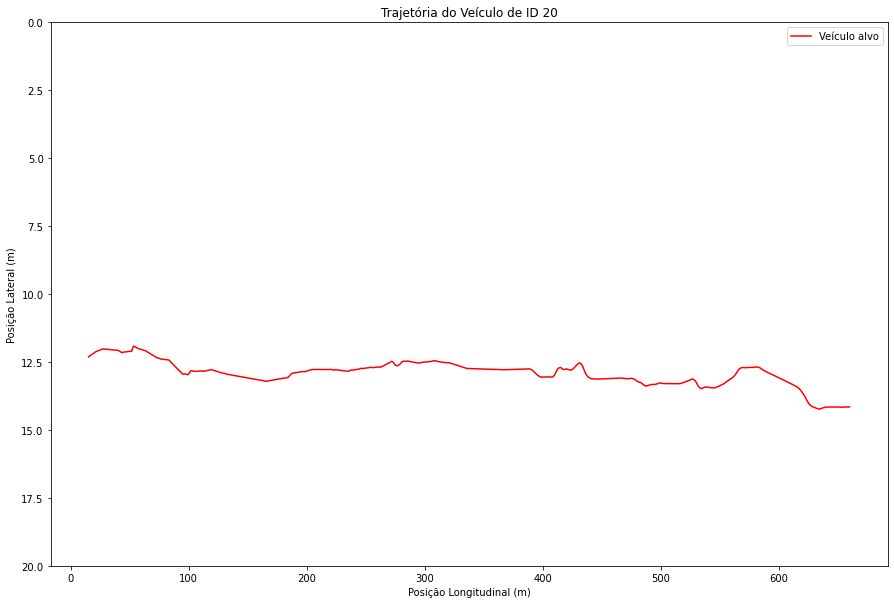

In [95]:
plt.figure(figsize=(15, 10))
line_red, = plt.plot(target_df['Local_Y_meters'], target_df['Local_X_meters'], color='red', label='Veículo alvo')
plt.title('Trajetória do Veículo de ID {}'.format(target_df['Vehicle_ID'][0]))
plt.ylabel('Posição Lateral (m)')
plt.xlabel('Posição Longitudinal (m)')
#plt.xticks(target_df['Local_Y_meters'])
plt.ylim(20, 0)
plt.legend(handles=[line_red,])

Gráfico comparativo entre a posição lateral real e a posição lateral após a aplicação do filtro no veículo alvo.

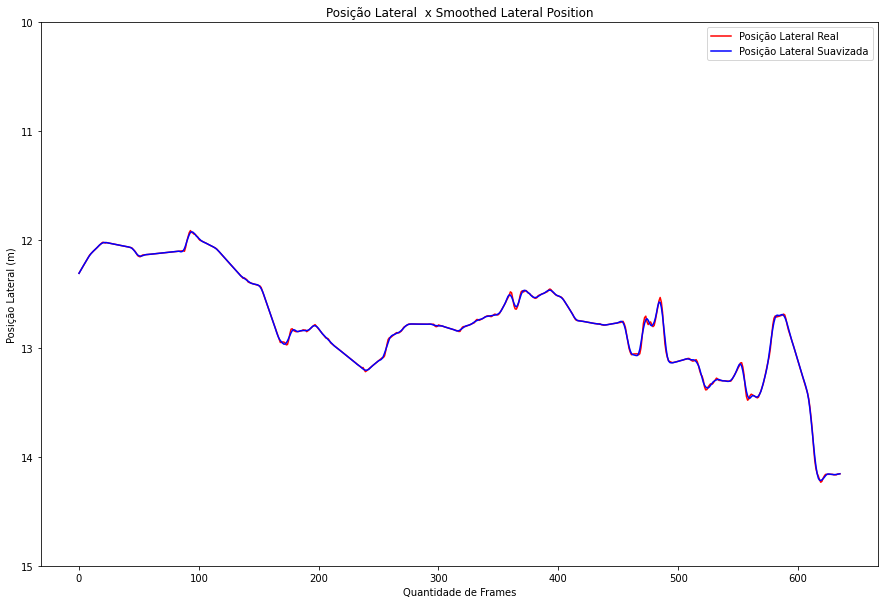

In [97]:
plt.figure(figsize=(15, 10))
line_red, = plt.plot(target_df['Local_X_meters'], color='red', label='Posição Lateral Real')
line_blue, = plt.plot(target_df['Local_X_filtered'], color='blue', label='Posição Lateral Suavizada')
plt.title('Posição Lateral  x Smoothed Lateral Position')
plt.xlabel('Quantidade de Frames')
plt.ylabel('Posição Lateral (m)')
plt.ylim(15, 10)
plt.legend(handles=[line_red, line_blue])

Gerando um _DataFrame_ do veículo atrás (behind_df) do veículo alvo.

In [98]:
%%time
behind_df = pp.get_preceeding_or_following_dataframe(df, target_df)
behind_df = pp.application_of_savgol_filter_and_return_dataframe(behind_df)

[20]
CPU times: user 95.6 ms, sys: 24.1 ms, total: 120 ms
Wall time: 117 ms


In [99]:
behind_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,25,900,1118847932000,53.977,2000.996,16.452390,609.910997,56.40,2,5,20,31,16.440530,611.463390
1,25,901,1118847932100,53.972,2006.579,16.450866,611.612716,55.07,2,5,20,31,16.475361,611.747345
2,25,902,1118847932200,54.091,2011.979,16.487137,613.258656,53.38,2,5,20,31,16.502368,612.450563
3,25,903,1118847932300,54.243,2017.259,16.533467,614.868020,52.27,2,5,20,31,16.521552,613.573042
4,25,904,1118847932400,54.346,2022.344,16.564862,616.417947,52.18,2,5,20,31,16.532913,615.114784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,26,912,1118847933200,41.211,1993.868,12.561266,607.738356,55.32,2,4,20,34,12.637608,606.367011
576,26,913,1118847933300,41.387,1999.473,12.614911,609.446781,56.08,2,4,20,34,12.658277,609.316844
577,26,914,1118847933400,41.640,2005.183,12.692026,611.187210,56.05,2,4,20,34,12.690937,611.736929
578,26,915,1118847933500,41.863,2010.788,12.759998,612.895635,55.16,2,4,20,34,12.735591,613.627266


Gerando um _DataFrame_ do veículo à frente (front_df) do veículo alvo.

In [100]:
front_df = pp.get_preceeding_or_following_dataframe(df, target_df, "following")
front_df = pp.application_of_savgol_filter_and_return_dataframe(front_df)

[20]


In [101]:
front_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,14,285,1118847870500,38.884,98.889,11.851987,30.141734,25.00,2,4,10,20,11.850355,30.115836
1,14,286,1118847870600,38.871,101.387,11.848025,30.903133,25.01,2,4,10,20,11.848253,30.912675
2,14,287,1118847870700,38.858,103.891,11.844062,31.666362,25.03,2,4,10,20,11.845858,31.692022
3,14,288,1118847870800,38.846,106.408,11.840405,32.433553,24.92,2,4,10,20,11.843169,32.453876
4,14,289,1118847870900,38.834,108.917,11.836747,33.198305,24.52,2,4,10,20,11.840187,33.198238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,21,902,1118847932200,56.920,2141.835,17.349427,652.839247,58.99,2,5,0,20,16.985053,652.963357
618,21,903,1118847932300,56.903,2147.683,17.344245,654.621739,58.74,2,5,0,20,17.298428,654.552489
619,21,904,1118847932400,56.899,2153.410,17.343026,656.367349,58.74,2,5,0,20,17.480951,656.259598
620,21,905,1118847932500,56.894,2159.410,17.341502,658.196172,58.74,2,5,0,20,17.532622,658.084683


In [102]:
test_df = front_df.loc[front_df['Preceeding'] != 0]
len(test_df)

614

Gerando um _DataFrame_ do veículo à frente do veículo à frente (front_front_df) do alvo.

In [105]:
front_front_df = pp.get_preceeding_or_following_dataframe(df, front_df, "following")
front_front_df = pp.application_of_savgol_filter_and_return_dataframe(front_front_df)

[14 21]


In [106]:
front_front_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,10,285,1118847870500,39.901,147.530,12.161973,44.967691,15.66,2,4,2,14,12.161973,44.967727
1,10,286,1118847870600,39.920,149.097,12.167764,45.445318,15.67,2,4,2,14,12.167764,45.445244
2,10,287,1118847870700,39.939,150.663,12.173555,45.922641,15.67,2,4,2,14,12.173555,45.922751
3,10,288,1118847870800,39.958,152.230,12.179347,46.400268,15.67,2,4,2,14,12.179347,46.400248
4,10,289,1118847870900,39.977,153.797,12.185138,46.877896,15.67,2,4,2,14,12.185138,46.877735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,11,872,1118847929200,35.408,2041.234,10.792490,622.175689,51.39,2,4,10,14,11.550279,633.005892
610,11,873,1118847929300,35.405,2046.293,10.791575,623.717691,50.53,2,4,10,14,11.196804,629.654093
611,11,874,1118847929400,35.316,2051.282,10.764448,625.238356,50.08,2,4,10,14,10.875530,626.804857
612,11,875,1118847929500,35.257,2056.251,10.746464,626.752926,50.04,2,4,10,14,10.586459,624.458186


Foi criado o método __get_left_or_right_vehicle_dataframe()__ para gerar um _DataFrame_ com todas as linhas dos veículos à esquerda ou à direita do veículo alvo.

Os parâmentros para _get_left_or_right_vehicle_dataframe()_ são:
* __full_df__: _DataFrame_ que contém todas os dados completos
* __target_df__: _DataFrame_ que contém as informações do veículo alvo
* __side__: qual o lado que os veículos buscados estará em relação ao alvo. Pode ser _Left_ ou _Right_.

Gerando um _DataFrame_ do veículo à esquerda (left_df) do veículo alvo.

In [107]:
%%time
left_df = pp.get_left_or_right_vehicle_dataframe(df, target_df)
left_df = pp.application_of_savgol_filter_and_return_dataframe(left_df)

CPU times: user 1min 13s, sys: 0 ns, total: 1min 13s
Wall time: 1min 13s


In [108]:
left_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,19,366,1118847878600,27.617,162.913,8.417764,49.656486,17.84,2,3,15,27,8.334429,42.923658
1,19,367,1118847878700,27.555,164.697,8.398866,50.200256,17.84,2,3,15,27,8.367594,47.476417
2,19,368,1118847878800,27.494,166.481,8.380273,50.744026,17.84,2,3,15,27,8.406417,52.622610
3,19,369,1118847878900,27.432,168.265,8.361375,51.287796,17.84,2,3,15,27,8.450898,58.362236
4,19,370,1118847879000,27.371,170.049,8.342782,51.831565,17.84,2,3,15,27,8.501038,64.695296
5,19,371,1118847879100,27.309,171.831,8.323884,52.374726,17.87,2,3,15,27,8.556837,71.621790
6,19,460,1118847888000,29.292,332.890,8.928310,101.466106,23.10,2,3,15,27,8.652660,82.297659
7,19,461,1118847888100,29.072,335.161,8.861253,102.158315,23.10,2,3,15,27,8.742844,92.445257
8,19,462,1118847888200,28.904,337.465,8.810046,102.860583,23.40,2,3,15,27,8.815441,100.932723
9,19,463,1118847888300,28.873,339.832,8.800597,103.582053,23.77,2,3,15,27,8.857975,106.623490


In [109]:
left_df.shape
# (linhas, colunas)

(55, 14)

Gerando um _DataFrame_ do veículo atrás do veículo à esquerda (behind_left_df) do alvo.

In [110]:
behind_left_df = pp.get_preceeding_or_following_dataframe(df, left_df)
behind_left_df = pp.application_of_savgol_filter_and_return_dataframe(behind_left_df)

[19]


In [111]:
behind_left_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,27,366,1118847878600,26.954,102.596,8.215679,31.271641,16.67,2,3,19,0,8.142750,24.605309
1,27,367,1118847878700,26.945,104.262,8.212936,31.779444,16.67,2,3,19,0,8.184413,29.104970
2,27,368,1118847878800,26.937,105.929,8.210497,32.287552,16.67,2,3,19,0,8.231822,34.168067
3,27,369,1118847878900,26.928,107.595,8.207754,32.795355,16.67,2,3,19,30,8.284980,39.794600
4,27,370,1118847879000,26.920,109.262,8.205316,33.303463,16.67,2,3,19,30,8.343884,45.984570
5,27,371,1118847879100,26.911,110.928,8.202573,33.811266,16.67,2,3,19,30,8.408535,52.737976
6,27,460,1118847888000,28.639,269.163,8.729273,82.041880,20.42,2,3,19,30,8.510834,63.166066
7,27,461,1118847888100,28.594,271.122,8.715557,82.638990,19.03,2,3,19,30,8.607802,73.041650
8,27,462,1118847888200,28.549,272.966,8.701841,83.201049,18.04,2,3,19,30,8.688542,81.263454
9,27,463,1118847888300,28.538,274.626,8.698488,83.707023,18.04,2,3,19,30,8.741682,86.722755


In [112]:
behind_left_df.shape

(55, 14)

Gerando um _DataFrame_ do veículo à frente do veículo à esquerda (front_left_df) do alvo.

In [113]:
front_left_df = pp.get_preceeding_or_following_dataframe(df, left_df, "following")
front_left_df = pp.application_of_savgol_filter_and_return_dataframe(front_left_df)

[19]


In [114]:
front_left_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,15,366,1118847878600,27.860,198.762,8.491831,60.583394,15.62,2,3,11,19,8.441549,53.624945
1,15,367,1118847878700,27.879,200.324,8.497623,61.059498,15.62,2,3,11,19,8.477637,58.209981
2,15,368,1118847878800,27.899,201.886,8.503719,61.535601,15.62,2,3,11,19,8.517874,63.443600
3,15,369,1118847878900,27.918,203.472,8.509510,62.019020,15.41,2,3,11,19,8.562259,69.325803
4,15,370,1118847879000,27.937,205.012,8.515301,62.488417,14.92,2,3,11,19,8.610793,75.856588
5,15,371,1118847879100,27.956,206.455,8.521092,62.928249,14.57,2,3,11,19,8.663475,83.035957
6,15,460,1118847888000,29.154,374.100,8.886247,114.027067,27.25,2,3,11,19,8.743735,94.148537
7,15,461,1118847888100,29.172,376.825,8.891734,114.857657,27.25,2,3,11,19,8.819779,104.750799
8,15,462,1118847888200,29.191,379.550,8.897525,115.688247,27.25,2,3,11,19,8.882425,113.654427
9,15,463,1118847888300,29.209,382.274,8.903011,116.518532,27.25,2,3,11,19,8.923473,119.660313


In [115]:
front_left_df.shape

(55, 14)

Gerando um _DataFrame_ do veículo à direita (right_df) do veículo alvo.

In [116]:
%%time
right_df = pp.get_left_or_right_vehicle_dataframe(df, target_df, 'right')
right_df = pp.application_of_savgol_filter_and_return_dataframe(right_df)

CPU times: user 1min 13s, sys: 77.7 ms, total: 1min 13s
Wall time: 1min 13s


In [117]:
right_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,16,409,1118847882900,52.324,221.884,15.948549,67.631066,27.23,2,5,6,21,16.114411,165.737761
1,21,675,1118847909500,53.680,999.883,16.361863,304.768044,52.46,2,5,16,25,16.244566,219.272067
2,21,685,1118847910500,54.060,1040.820,16.477688,317.245794,32.47,2,5,16,25,16.354035,263.972559
3,21,686,1118847910600,54.078,1044.103,16.483175,318.246464,33.67,2,5,16,25,16.442816,299.839236
4,21,687,1118847910700,54.087,1047.593,16.485918,319.310229,35.73,2,5,16,25,16.510910,326.872100
5,21,693,1118847911300,54.251,1072.904,16.535906,327.025116,45.02,2,5,16,25,16.558318,345.071150
6,21,694,1118847911400,54.258,1077.402,16.538040,328.396123,45.00,2,5,16,25,16.538102,328.045577
7,21,695,1118847911500,54.264,1081.902,16.539868,329.767740,45.00,2,5,16,25,16.548930,330.383878
8,21,696,1118847911600,54.272,1086.402,16.542307,331.139356,45.00,2,5,16,25,16.554021,332.159350
9,21,697,1118847911700,54.278,1090.901,16.544136,332.510668,45.00,2,5,16,25,16.553375,333.371991


Gerando um _DataFrame_ do veículo atrás do veículo à direita (behind_left_df) do alvo.

In [118]:
behind_right_df = pp.get_preceeding_or_following_dataframe(df, right_df)
behind_right_df = pp.application_of_savgol_filter_and_return_dataframe(behind_right_df)

[16 21]


In [119]:
behind_right_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,21,409,1118847882900,52.863,144.804,16.112838,44.136796,22.62,2,5,16,25,15.783318,137.301694
1,25,675,1118847909500,50.148,884.483,15.285296,269.593697,34.82,2,5,21,31,15.600031,188.169758
2,25,685,1118847910500,50.282,921.511,15.326140,280.879968,40.00,2,5,21,31,15.449164,230.634772
3,25,686,1118847910600,50.093,925.503,15.268532,282.096745,39.98,2,5,21,31,15.330718,264.696738
4,25,687,1118847910700,49.962,929.501,15.228603,283.315350,39.99,2,5,21,31,15.244691,290.355655
5,25,693,1118847911300,50.039,953.211,15.252073,290.542246,39.47,2,5,21,31,15.191084,307.611523
6,25,694,1118847911400,50.072,957.194,15.262131,291.756279,39.84,2,5,21,31,15.259729,291.400656
7,25,695,1118847911500,50.105,961.211,15.272190,292.980675,40.00,2,5,21,31,15.264001,293.567960
8,25,696,1118847911600,50.138,965.211,15.282248,294.199890,40.00,2,5,21,31,15.272417,295.187504
9,25,697,1118847911700,50.171,969.211,15.292307,295.419105,40.00,2,5,21,31,15.284976,296.259288


Gerando um _DataFrame_ do veículo à frente do veículo à direita (front_right_df) do alvo.

In [121]:
front_right_df = pp.get_preceeding_or_following_dataframe(df, right_df, "following")
front_right_df = pp.application_of_savgol_filter_and_return_dataframe(front_right_df)

[16 21]


In [122]:
front_right_df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Local_X_meters,Local_Y_meters,v_Vel,v_Class,Lane_ID,Preceeding,Following,Local_X_filtered,Local_Y_filtered
0,6,409,1118847882900,52.838,339.245,16.105218,103.403133,26.06,2,5,1,16,16.002169,200.501632
1,16,675,1118847909500,52.061,1110.904,15.868386,338.607657,45.00,2,5,1,21,15.964705,254.313436
2,16,685,1118847910500,52.130,1155.904,15.889417,352.323823,45.00,2,5,1,21,15.934114,299.267200
3,16,686,1118847910600,52.136,1160.404,15.891246,353.695440,45.00,2,5,1,21,15.910398,335.362924
4,16,687,1118847910700,52.143,1164.904,15.893380,355.067057,45.00,2,5,1,21,15.893556,362.600608
5,16,693,1118847911300,52.185,1191.895,15.906181,363.294014,45.08,2,5,1,21,15.883588,380.980252
6,16,694,1118847911400,52.192,1196.404,15.908315,364.668374,45.27,2,5,1,21,15.907679,364.338783
7,16,695,1118847911500,52.199,1200.950,15.910449,366.054011,45.40,2,5,1,21,15.909962,366.823262
8,16,696,1118847911600,52.198,1205.510,15.910144,367.443916,45.40,2,5,1,21,15.910655,368.653801
9,16,697,1118847911700,52.192,1210.056,15.908315,368.829554,45.27,2,5,1,21,15.909756,369.830400


Adição de sufixos às colunas dos _DataFrames_ gerados para indentificação após o _merge_. Os sufixos são:
* __target_df:__ targ
* __behind_df:__ b
* __front_df:__ f
* __front_front_df:__ ff
* __left_df:__ l
* __behind_left_df:__ bl
* __front_left_df:__ fl
* __right_df:__ r
* __behind_right_df:__ br
* __front_right_df:__ fr

In [ ]:
s_target_df = target_df.copy()
s_behind_df = behind_df.copy()
s_front_df = front_df.copy()
s_front_front_df = front_front_df.copy()
s_left_df = left_df.copy()
s_behind_left_df = behind_left_df.copy()
s_front_left_df = front_left_df.copy()
s_right_df = right_df.copy()
s_behind_right_df= behind_right_df.copy()
s_front_right_df = front_right_df.copy()

In [ ]:
def get_final_target_dataframe(target_df, start_index):
    new_df = pd.DataFrame(columns=['Vehicle_ID', 
                                   'Frame_ID',
                                   'Global_Time',
                                   'Local_X',
                                   'Local_Y',
                                   'Local_X_meters',
                                   'Local_Y_meters',
                                   'Local_X_Vel',
                                   'Local_Y_Vel',
                                   'v_Class'])
    
    for row in target_df.itertuples():
        if row.Index > start_index:
            time = (row.Global_Time - target_df['Global_Time'][row.Index-1]) / 1000
            local_x_vel = (row.Local_X_meters - target_df['Local_X_meters'][row.Index-1]) / time
            local_y_vel = (row.Local_Y_meters - target_df['Local_Y_meters'][row.Index-1]) / time
            new_df = new_df.append({'Vehicle_ID': row.Vehicle_ID,
                                       'Frame_ID': row.Frame_ID,
                                       'Global_Time': row.Global_Time,
                                       'Local_X': row.Local_X,
                                       'Local_Y': row.Local_Y,
                                       'Local_X_meters': row.Local_X_meters,
                                       'Local_Y_meters': row.Local_Y_meters,
                                       'Local_X_Vel': local_x_vel,
                                       'Local_Y_Vel': local_y_vel,
                                       'v_Class': row.v_Class}, ignore_index=True)
        
    new_df = new_df.astype({'Vehicle_ID': 'int', 
                            'Frame_ID': 'int',
                            'Global_Time': 'int',
                            'v_Class': 'int'})
        
    return new_df

In [ ]:
s_target_df = get_final_target_dataframe(s_target_df, s_target_df.index.start)
s_target_df.head()

In [ ]:
s_target_df.tail()

In [ ]:
s_behind_df.head()

In [ ]:
def get_final_surround_dataframe(surround_df, target_df):
    new_df = pd.DataFrame(columns=['Frame_ID',
                                   'Local_X_Vel',
                                   'Relative_Y_Vel',
                                   'Relative_Targ_X',
                                   'Relative_Targ_Y', 
                                   'Time_To_Collision',
                                   'v_Class'])
    
    if surround_df.empty:
        return new_df
    
    start_index = surround_df.index.start
    
    for row in surround_df.itertuples():
        if row.Index > start_index:
            time = (row.Global_Time - surround_df['Global_Time'][row.Index-1]) / 1000
            local_x_vel = (row.Local_X_meters - surround_df['Local_X_meters'][row.Index-1]) / time
            local_y_vel = (row.Local_Y_meters - surround_df['Local_Y_meters'][row.Index-1]) / time
            
            for line in target_df.itertuples():
                if row.Frame_ID == line.Frame_ID:
                    relative_y_vel = line.Local_Y_Vel - local_y_vel
                    local_x_targ = row.Local_X_meters - line.Local_X_meters
                    local_y_targ = row.Local_Y_meters - line.Local_Y_meters
                    ttc = local_y_targ / relative_y_vel
            
                    new_df = new_df.append({'Frame_ID': row.Frame_ID,
                                            'Local_X_Vel': local_x_vel,
                                            'Relative_Y_Vel': relative_y_vel, 
                                            'Relative_Targ_X': local_x_targ, 
                                            'Relative_Targ_Y': local_y_targ,
                                            'Time_To_Collision': ttc,
                                            'v_Class': row.v_Class}, ignore_index=True)
                    break
        
    new_df = new_df.astype({'Frame_ID': 'int',
                            'v_Class': 'int'})
        
    return new_df

In [ ]:
s_behind_df = get_final_surround_dataframe(s_behind_df, s_target_df)
s_behind_df.head()

In [ ]:
s_behind_df.tail()

In [ ]:
s_front_df = get_final_surround_dataframe(s_front_df, s_target_df)
s_front_front_df = get_final_surround_dataframe(s_front_front_df, s_target_df)
s_left_df = get_final_surround_dataframe(s_left_df, s_target_df)
s_behind_left_df = get_final_surround_dataframe(s_behind_left_df, s_target_df)
s_front_left_df = get_final_surround_dataframe(s_front_left_df, s_target_df)
s_right_df = get_final_surround_dataframe(s_right_df, s_target_df)
s_behind_right_df = get_final_surround_dataframe(s_behind_right_df, s_target_df)
s_front_right_df = get_final_surround_dataframe(s_front_right_df, s_target_df)

In [ ]:
s_target_df.columns = s_target_df.columns.map(lambda x: str(x) + '_targ' if str(x) != 'Frame_ID' else str(x))
s_behind_df.columns = s_behind_df.columns.map(lambda x: str(x) + '_b' if str(x) != 'Frame_ID' else str(x))
s_front_df.columns = s_front_df.columns.map(lambda x: str(x) + '_f' if str(x) != 'Frame_ID' else str(x))
s_front_front_df.columns = s_front_front_df.columns.map(lambda x: str(x) + '_ff' if str(x) != 'Frame_ID' else str(x))
s_left_df.columns = s_left_df.columns.map(lambda x: str(x) + '_l' if str(x) != 'Frame_ID' else str(x))
s_behind_left_df.columns = s_behind_left_df.columns.map(lambda x: str(x) + '_bl' if str(x) != 'Frame_ID' else str(x))
s_front_left_df.columns = s_front_left_df.columns.map(lambda x: str(x) + '_fl' if str(x) != 'Frame_ID' else str(x))
s_right_df.columns = s_right_df.columns.map(lambda x: str(x) + '_r' if str(x) != 'Frame_ID' else str(x))
s_behind_right_df.columns = s_behind_right_df.columns.map(lambda x: str(x) + '_br' if str(x) != 'Frame_ID' else str(x))
s_front_right_df.columns = s_front_right_df.columns.map(lambda x: str(x) + '_fr' if str(x) != 'Frame_ID' else str(x))

In [ ]:
dfs = [s_target_df, 
       s_behind_df, 
       s_front_df, 
       s_front_front_df, 
       s_left_df, 
       s_behind_left_df, 
       s_front_left_df, 
       s_right_df, 
       s_behind_right_df, 
       s_front_right_df]
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['Frame_ID'],
                                               suffixes=(False, False),
                                               how='outer'), dfs).fillna(0)
final_df.head()

In [ ]:
final_df.tail()

Validar dados do target_df:

In [ ]:
def lateral_velocity_target_validation(final_df):
    validation = True
    
    for row in final_df.itertuples():
        if row.Index > 0:
            local_x_distance = row.Local_X_meters_targ - final_df['Local_X_meters_targ'][row.Index-1]
            local_x_time = (row.Global_Time_targ - final_df['Global_Time_targ'][row.Index-1])/1000
            local_x_vel_real = row.Local_X_Vel_targ
            local_x_vel_test = local_x_distance / local_x_time
            
            if local_x_vel_test != local_x_vel_real:
                validation = False
 
                print('Veículo', row.Vehicle_ID_targ, 'Frame', row.Frame_ID)
                print('Resultado: ', local_x_vel_real)
                print('Esperado: ', local_x_vel_test)
                break
            
    
    if validation == True:
        print('Velocidades laterais corretas.')

In [ ]:
lateral_velocity_target_validation(final_df)

In [ ]:
def longitudinal_velocity_target_validation(final_df):
    validation = True
    
    for row in final_df.itertuples():
        if row.Index > 0:
            local_y_distance = row.Local_Y_meters_targ - final_df['Local_Y_meters_targ'][row.Index-1]
            local_y_time = (row.Global_Time_targ - final_df['Global_Time_targ'][row.Index-1])/1000
            local_y_vel_real = row.Local_Y_Vel_targ
            local_y_vel_test = local_y_distance / local_y_time
            
            if local_y_vel_test != local_y_vel_real:
                validation = False
 
                print('Veículo', row.Vehicle_ID_targ, 'Frame', row.Frame_ID)
                print('Resultado: ', local_y_vel_real)
                print('Esperado: ', local_y_vel_test)
                break
            
    
    if validation == True:
        print('Velocidades longitudinais corretas.')

In [ ]:
longitudinal_velocity_target_validation(final_df)

In [ ]:
def lateral_velocity_surrounds_validation(final_df, surround_df, suffix):
    local_x_name = 'Local_X_meters_'+suffix
    local_x_vel_name = 'Local_X_Vel_'+suffix
    global_time_name = 'Global_Time_'+suffix
    vehicle_id_name = 'Vehicle_ID_'+suffix
    validation = True
    
    for row in final_df.itertuples():
        if final_df[local_x_vel_name][row.Index] != 0:
            local_x_distance = surround_df['Local_X_meters'][row.Frame_ID] - final_df['Local_X_meters'][row.Frame_ID-1]
            local_x_time = (final_df[global_time_name][row.Index] - final_df[global_time_name][row.Index-1])/1000
            local_x_vel_real = final_df[local_x_vel_name][row.Index]
            local_x_vel_test = local_x_distance / local_x_time
            
            if local_x_vel_test != local_x_vel_real:
                validation = False
 
                print('Veículo', final_df[vehicle_id_name][row.Index], 'Frame', row.Frame_ID)
                print('Resultado: ', local_x_vel_real)
                print('Esperado: ', local_x_vel_test)
                break
            
    
    if validation == True:
        print('Velocidades laterais corretas.')

In [ ]:
lateral_velocity_surrounds_validation(final_df, left_df, 'l')

In [ ]:
lateral_velocity_surrounds_validation(final_df, left_df, 'l')
lateral_velocity_surrounds_validation(final_df, 'bl')
lateral_velocity_surrounds_validation(final_df, 'fl')
lateral_velocity_surrounds_validation(final_df, 'r')
lateral_velocity_surrounds_validation(final_df, 'br')
lateral_velocity_surrounds_validation(final_df, 'bl')
lateral_velocity_surrounds_validation(final_df, 'f')
lateral_velocity_surrounds_validation(final_df, 'ff')
lateral_velocity_surrounds_validation(final_df, 'b')

In [ ]:
def relative_longitudinal_velocity_surrounds_validation(final_df, suffix):
    local_y_name = 'Local_Y_meters_'+suffix
    relative_y_vel_name = 'Relative_Y_Vel_'+suffix
    global_time_name = 'Global_Time_'+suffix
    vehicle_id_name = 'Vehicle_ID_'+suffix
    validation = True
    
    for row in final_df.itertuples():
        if row.Index > 0 and final_df[local_y_name][row.Index] != 0 and final_df[local_y_name][row.Index-1] != 0:
            local_y_distance = final_df[local_y_name][row.Index] - final_df[local_y_name][row.Index-1]
            local_y_time = (final_df[global_time_name][row.Index] - final_df[global_time_name][row.Index-1])/1000
            local_y_vel = local_y_distance / local_y_time
            relative_y_vel_real = final_df[relative_y_vel_name][row.Index]
            relative_y_vel_test = row.Local_Y_Vel_targ - local_y_vel
            
            if relative_y_vel_test != relative_y_vel_real and not math.isnan(local_y_vel_test):
                validation = False
 
                print('Veículo', final_df[vehicle_id_name][row.Index], 'Frame', row.Frame_ID)
                print('Resultado: ', relative_y_vel_real)
                print('Esperado: ', relative_y_vel_test)
                break
            
    
    if validation == True:
        print('Velocidades longitudinais relativas em relação ao alvo corretas.')

In [ ]:
relative_longitudinal_velocity_surrounds_validation(final_df, 'l')
relative_longitudinal_velocity_surrounds_validation(final_df, 'bl')
relative_longitudinal_velocity_surrounds_validation(final_df, 'fl')
relative_longitudinal_velocity_surrounds_validation(final_df, 'r')
relative_longitudinal_velocity_surrounds_validation(final_df, 'br')
relative_longitudinal_velocity_surrounds_validation(final_df, 'bl')
relative_longitudinal_velocity_surrounds_validation(final_df, 'f')
relative_longitudinal_velocity_surrounds_validation(final_df, 'ff')
relative_longitudinal_velocity_surrounds_validation(final_df, 'b')

Pendências para finalizar a implementação:
* Verificar a necessidade de realizar ajustes no pré-processamento dos dados
* Modelar a Rede Neural para treinar e realizar a previsão das velocidades longitudinais futuras

_
_
_
_
_
_
_
_
_
_

In [ ]:
train_data = final_df.iloc[:70, 5:64].values
train_data[0:10]

In [ ]:
normalizer = MinMaxScaler(feature_range=(0, 1))
normalized_train = normalizer.fit_transform(train_data)
normalized_train[0:10]

In [ ]:
def dataset_with_look_back_for_multiple_predictors(dataset, look_back=1, initial_column=1, last_column=2, target_column=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), initial_column:last_column]
        dataX.append(a)
        dataY.append(dataset[i + look_back, target_column])
        
    return np.array(dataX), np.array(dataY)

In [ ]:
train_x, train_y = dataset_with_look_back_for_multiple_predictors(normalized_train, 4, 0, 58, 0)

In [ ]:
train_x[0]

In [ ]:
train_y[0]

O formato dos dados de treino aceito pelo método LSTM() do Keras. O formato é __(batch_size, timesteps, input_dim)__, onde:

* __batch_size:__ quantidade de linhas de dados de entrada
* __timesteps:__ quantidade de intervalos temporais. Ex: 5 em 5 linhas de dados de entrada.
* __input_dim:__ quantidade de atributos utilizados na previsão. Ex: Local_X e Local_Y = 2 atributos

In [ ]:
train_x.shape

# (batch_size, timesteps, input_dim)

Representação do modelo LSTM utilizado:

![modelo LSTM](./lstm_representation.png)

In [ ]:
model = Sequential()

# camada 1     
# units é a quantidade de células de memória
# return_sequences se for True retorna os valores de saída para a próxima camada
# input_shape recebe (timesteps, input_dim)
model.add(LSTM(units = 256, input_shape=(train_x.shape[1], train_x.shape[2])))
# O dropout é usado para evitar overfitting
model.add(Dropout(0.3))

# camada 2
model.add(Dense(units = 256, activation='tanh'))
model.add(Dropout(0.3))

# camada 3
model.add(Dense(units = 128, activation='tanh'))
model.add(Dropout(0.3))

# camada final com units de 1 para uma única saída
# activation define a função de ativação para o cálculo da última saída
model.add(Dense(units = 1, activation='tanh'))

# optimizer é a função utilizada para o cálculo do gradiente
# loss é o erro utilizado para o ajuste dos pesos
model.compile(optimizer="rmsprop", loss="mean_squared_error", 
              metrics=["mean_absolute_error"] )

# método para parada de treinamento antes do número de epochs definido
# monitor indica a função a ser verificada a melhora
# min_delta indica o valor mínimo de melhora aceito para não parar o treinamento
# patience indica o número de iterações do treino necessários com min_delta abaixo do esperado
es = EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1)

# epochs é a quantidade de vezes que ocorrerá o ajuste dos pesos
# batch size é o número de amostras por atualização de gradiente
model.fit(train_x, train_y, epochs=100, batch_size = 32)

model.summary()

In [ ]:
normalizer_predict = MinMaxScaler(feature_range=(0, 1))
normalizer_predict.fit_transform(train_data[:,5:6])

In [ ]:
predict_train = model.predict(train_x)
#predict_train = predict_train.reshape(-1, 1)
predict_train

In [ ]:
predict_train = normalizer_predict.inverse_transform(predict_train)
train_y = normalizer_predict.inverse_transform(train_y.reshape(-1, 1))

predict_train

In [ ]:
train_y

In [ ]:
plt.plot(train_y, color='red', label='Real Movement')
plt.plot(predict_train, color='blue', label='Predicted')
plt.title('Movement Prediction')
plt.xlabel('Index')
plt.ylabel('Movement')

In [ ]:
%%time
complete_df = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0805am-0820am/trajectories-0805am-0820am.csv')

In [ ]:
complete_df.head()

In [ ]:
complete_df.tail()